# **Excercise 1: Solve Burgers Equation using a Physics-informed Neural Networks (PINNs)**

In [ ]:
!pip install sciann
import sciann as sn 
import numpy as np 
import matplotlib.pyplot as plt
from numpy import pi
from sciann.utils.math import diff, sign, sin

**Burgers Problem**

The governing equation is:

$u_{,t} + uu_{,x} - (0.01/\pi)u_{,xx}=0,    t \ in [0,1], x \in [-1.1]$

\\
subject to

$u(t=0,x) = -sin(\pi x), u(t, x = -1) = u(x=1)=0$

**Step 1: Setting up the neural network**

The first step is to construct the approximation space.

The independent variables are:

The field variable is: $u(t, x)$

The neural network approximation is defined as:
$\hat{u}:(t,x) → N_u(t,x|W,b)$

Here, we use 8 hidden layers with 20 neural units and hyperbolic-tangent activation function.

In [2]:
x = sn.Variable('x')                                # Define input variables (Features)
t = sn.Variable('t')                                # Define input variables (Features)
u = sn.Functional('u', [t,x], 8*[20], 'tanh')       # Define Neurale Network

**Step 2: Setting up the optimzation problem**


The second step is to set up the optimization model using SciModel interface. Input variables are and targets are:


*   $L_1: u_{,t} + uu_{,x} - (0.01/\pi)u_{,xx}$

In [3]:
L1 = diff(u, t) + u*diff(u,x) - (0.01/pi)*diff(u, x, order=2)              # Define Differential Equation / Physics

*   $C_1: (1+\sign(0-t))(u+sin(\pi x))$
*   $C_2: (1+\sign(-1-x))u$
*   $C_3: (1+\sign(x-1))u$

In [4]:
TOL = 0.001
C1 = (1-sign(t - TOL)) * (u + sin(pi*x))    # Define Initial Conditions u(t = 0)
C2 = (1-sign(x - (-1+TOL))) * (u)           # Define Boundary Conditions u(x = -1)
C3 = (1+sign(x - ( 1-TOL))) * (u)           # Define Boundary Conditions u(x = 1)

Let's define the PINNs together with multiple objects now:


In [5]:
# Option 1: ADAM Optimiser 
m = sn.SciModel([x, t], [L1, C1, C2, C3])

# Option 2: BFGS Optimiser 
# m = sn.SciModel([x, t], [L1, C1, C2, C3], optimizer='scipy-l-bfgs-b')  

# **Training of the Physics-Informed Neural Network for Deformation of an undamped SDOF under forcing**

**Sampling (collocation) grid**

To train the network, we need to define a sampling (collocation) grid.


In [6]:
x_data, t_data = np.meshgrid(
    np.linspace(-1, 1, 100), 
    np.linspace(0, 1, 100)
)

**Training**

Now proform the training:

In [ ]:
h = m.train([x_data, t_data], 4*['zero'], learning_rate=0.002, epochs=5000, verbose=1)


Total samples: 10000 
Batch size: 64 
Total batches: 157 



**Testing**

1- eval without passing the model:
Not suggested - the data should be provided in 

*   the same order as it was defined in the functional: "u = sn.Functional('u', [t,x], 8*[20], 'tanh')"
*   u.eval([t_data, x_data])


2- eval with model (suggested):

*   the data should be provided in the same order as it was defined in the SciModel: "m = sn.SciModel([x, t], [L1, C1, C2, C3])"
*   u.eval(m, [x_data, t_data])


Text(0.5, 1.0, 'Convergence of the PINN')

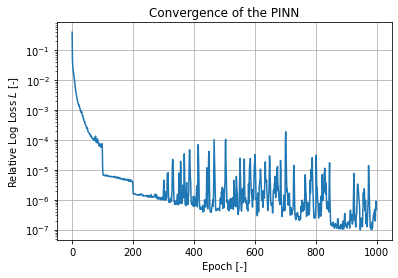

In [ ]:
plt.semilogy(h.history['loss'])
plt.ylabel('Relative Log Loss $L$ [-]')
plt.xlabel('Epoch [-]')
plt.grid('on')
#plt.ylim(10**-9,10**-6)
plt.title('Convergence of the PINN')

**2. Graphical comparison of the system responses of the PINN and the analytical reference solution**

In [ ]:
x_test, t_test = np.meshgrid(
    np.linspace(-1, 1, 200), 
    np.linspace(0, 1, 200)
)
u_pred = u.eval(m, [x_test, t_test])

fig = plt.figure(figsize=(3, 4))
plt.pcolor(x_test, t_test, u_pred, cmap='seismic')
plt.xlabel('Location $x~[m]$')
plt.ylabel('Time $t~[s]')
plt.title('System responses acc. to the PINN')
plt.grid('on')
plt.colorbar()
#plt.savefig('Burgers.pdf', pdi=300)